#### Tecnologias Utilizadas:

- Python 
- SageMath


# **El Gammal (PKE)**


**Public Key Encryption** é um tipo de criptografia assimétrica que utiliza um par de chaves: uma chave pública para cifrar mensagens e uma chave privada para decifrá-las. A principal característica do PKE é que a chave pública pode ser compartilhada abertamente, enquanto a chave privada deve ser mantida em segredo.

Com PKEs deixa de ser necessário um canal para partilhar chaves, já que basta cifrar algo com a chave publica do destinatário, o que garante que este será o único a conseguir decifrá-la.

### **1ª Etapa**

Começamos por gerar os parametros que seguem as restrições estabelecidas no enunciado:

#### **Parameteros**

- **Parametro de segurança (λ) = 128**

```py
        _lambda = 128  
        lambda_bits = _lambda.nbits() # 128 in binary is 10000000 -> 8 bits
```
Quanto maior lambda, mais seguro o sistema, mas em aplicações modernas lambda = 128 é o mais usual.

- **p : numero primo que define o grupo multiplicativo ℤₚ**
```py   
        while True:
            k = randint(min_k, max_k)
            p_candidate = k * q + 1
            if is_prime(p_candidate) and p_candidate.nbits() >= min_p_bits:
                p = p_candidate
                break
            k += 1
```
Isto significa que teremos um grupo com numeros de 1 a p-1, sendo este ultimo divisivel por q.
Segundo o enunciado este terá ∣p∣≥λ×∣λ∣​ que neste caso serão 1024 bits.

- **q : numero primo que define a ordem do subgrupo**
```py 
        lower_bound = 2^(_lambda - 1)
        upper_bound = 2^_lambda - 1
        q_candidate = randint(lower_bound, upper_bound)
        q = next_prime(q_candidate)
```
Garante a existencia do subgrupo e afeta diretamente a segurança do sistema: pois quanto maior lambda, maior q e maior é a resistencia do sistema contra ataques de logaritmo discreto.

- **g : gerador do subgrupo de ordem g**

```py
        while True:
            a = randint(2, p - 2)
            g = power_mod(a, (p - 1) // q, p)
            if g != 1:
                break
```
O conjunto {g¹, g², g³, ..., g^q} gera todos os elementos do subgrupo

#### **Par de Chaves**

- **s : chave privada**

```py
        s = randint(1, q-1)
```

Numero aleatório entre 1 e q-1 que é mantido em segredo pelo proprietário e só usado para decifrar

- **h : chave publica**

```py
        h = power_mod(g, s, p)
```
Esta chave é usada para cifrar as mensagens. É muito dificil chegar a s a partir de h (problema do logaritmo discreto)




### **2ª Etapa**

Após gerar os parametros podemos cifrar o texto. Este processo é probabilistico, o que significa que para a mesma mensagem podemos obter cifras diferentes, o que aumenta significativamente a segurança do sistema.

Começamos por gerar 

```py
        omega = randint(0, q-1)
```

De seguida usamos omega para gerar gamma e kappa.

```py
        gamma = power_mod(g,omega,p)
        kappa = power_mod(h,omega,p)
```

gamma faz parte do texto cifrado e é necessário para decifrar o ciphertext.

```py
        ciphertext = (mapped_plaintext * kappa) % p
```

Como vemos kappa é usado para cifrar o texto que será depois enviado ao recetor na forma (gamma,ciphertext)

```py
        return gamma,ciphertext
```

### **3ª Etapa**

Para decifrar o ciphertext o receiver vai usar a chave privada s e o gamma. 

Começamos por fazer a operação reversa e obter kappa e o seu inverso.

```py
        kappa = power_mod(gamma, private_key, p)
        kappa_inv = power_mod(kappa, -1, p)
```

Como é normal em esquemas PKE, a chave privada é então usada para decifrar o texto:

```py
    m = (ciphertext * kappa_inv) % p
```


# **El Gammal + Fujisaki-Okamoto (PKE)**

A transformação de Fujisaki-Okamoto é um método que fortalece esquemas de encriptação probabilística, como o ElGamal que são IND-CPA.
Esta transformação permite converter um esquema de cifra IND-CPA seguro para IND-CCA o que significa que o adversário não consegue distinguir entre duas mensagens cifradas, nem descobrir o nosso texto mesmo tendo acesso ao oráculo de decifrar.

Isto é alcançado da seguinte forma:
 - é incluído um parametro **r**  que adiciona **aleatoriedade** ao cifrar os dados
 - é incluido um **hash** no ciphertext que nos permite verificar a **autenticidade** dos mesmos

Os parametros gerados pelo EL Gammal são os mesmos e esse processo é descrito a cima, por isso vamos nos focar nas diferenças que a transformação acrescenta

### **1ª Etapa**

Começamos por gerar $r$

```py
        r = randint(1, q - 1)
```

Este parametro substitui omega nos calculos de gamma e kappa, sendo depois combinado com o plaintext e cifrado com o mesmo. Isto vai nos permitir recuperar este valor mais tarde, o que possibilita a decifração do mesmo.
Este passo é também das maiores valências da transformação, já que adiciona segurança ao fazer uso de um valor aleatório que é misturado com os dados.

```py
        combined = (r << 128) + m_int
               
```
A transformação acaba com o cáculo do Hash deste r e com o seu posterior envio, assim o que é enviado para o receiver é o tuplo (Hash(r), gamma, ciphertext).

```py
        c_2 = H(r)
        c_1 = (gamma, ciphertext)
        
        return c_1, c_2
```

### **2ª Etapa**

Para decifrar o processo é mais uma vez análogo ao do El Gammal: começamos por calcular kappa e o seu inverso e apartir daí deciframos o texto.

```py
        combined = (encrypted_message * kappa_inv) % p
```
No entanto, como vimos ao cifrar, o r é combinado com o plaintext, por isso este tem que ser extraído

```py
        r = combined >> 128 
```


Com r retirado, podemos agora ver se os dados foram comprometidos calculado o hash do mesmo e comparando com o que nos foi enviado, algo que com o simples El Gammal nãp podia ser feito.


```py

        r_hash_calculated = H(r)
        if r_hash_calculated != c_2:
            raise ValueError("Ciphertext integrity check failed. The ciphertext may have been changed.")

```

Com isto calculado temos a certeza que os nossos dados nao foram adulterados, obtendo assim o nosso plaintext 

# **El Gammal + Fujisaki-Okamoto (KEM)**

O objetivo era fazer um KEM que fosse IND-CCA seguro.

Para isso foi usada a implementação feita em 1(b)

O Key Encapsulation Mechanism (KEM) é um esquema criptográfico projetado especificamente para gerar e proteger chaves simétricas de forma segura. O KEM é utilizado para gerar uma chave simétrica aleatória e encapsulá-la de forma segura, permitindo que ela seja transmitida através de canais inseguros.

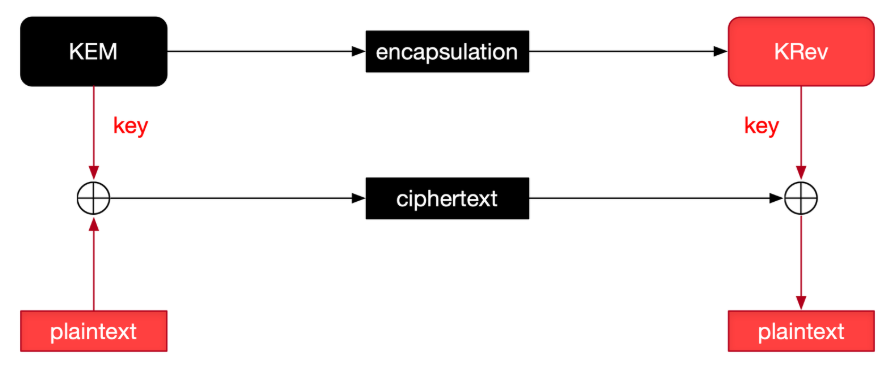

### **1ª Etapa**

Como feito anteriormente, começamos por gerar as chaves públicas e privadas a partir do El Gammal:

```py
    
    pk = (p, q, g, h)
    sk = s
    
    return pk, sk

```

### **2ª Etapa - Encapsulamento**

Num esquema normal pegamos num texto, uma mensagem de um user por exemplo, e ciframos esse texto, num KEM, geramos um chave aleatória e encapsulamos essa chave

Começamos por gerar uma chave de 128 bits 

```py
        key_bytes = os.urandom(16)
```

De seguida esta key é tratada como se fosse o plaintext do El Gammal + Fujisaki Okamoto (IND-CCA) e é então encapsulada, usando r e kappa .

```py 
        combined = (r << 128) + key
        ciphertext = (combined * kappa) % p
```

O encapsulamento é depois enviado para o receiver.

```py
        encapsulation = (gamma, ciphertext, r_hash)
```

### **2ª Etapa - Cifrar o texto**

A par do encapsulamento, temos que enviar ainda o texto cifrado.
No nosso caso, escolhemos cifrar o texto fazendo um xor do plaintext com a key gerada:

```py
        ciphertext = bytearray()
        
        for m, k in zip(message_bytes, key_bytes):
            ciphertext.append(int(m).__xor__(int(k)))
```

Notar que aqui foi usado ```__xor__``` em vez de ```^``` para a operação de xor por causa de um bug na tradução de operações

### **3ª Etapa - Desencapsular**


O receiver tem agora que desencapsular a key.

Isto é análogo a decifrar um texto no El Gammal + Fujisaki Okamoto, em que calculamos kappa usando a chave privada, usamos r para verificar a integridade da key (key foi cifrada como r + key) e então concluímos se esta é a key que queremos

```py
        r = combined >> 128
        key_int = combined & ((1 << 128) - 1)

        if r_hash_calculated != r_hash:
            raise ValueError("Encapsulation integrity check failed")
    
        return key_bytes
```

### **3ª Etapa - Decifrar**

Tendo a key desencapsulada e o ciphertext recebido, só temos que fazer um xor entre o ciphertext e a key e obtemos o plaintext:

```py
        for c, k in zip(ciphertext, key_bytes):
            plaintext_bytes.append(int(c).__xor__(int(k)))

        return plaintext_bytes
```

# **κ-out-of-n OBLIVIOUS TRANSFER (OT)**


O OT é um protocolo que envolve dois agentes - Provider e Receiver.

Neste protocolo o **Provider** tem um **conjunto de mensagens**, **n**, e o **receiver** quer receber um **subgrupo dessas mensagens**, **k**. 

A magia deste esquema está no facto de o **Provider não saber que mensagens o Receiver recebeu** e ainda o **Receiver conhece apenas as mensagens que escolheu**, nem mais nem menos. 


### **1ª Etapa - Gerar Oblivious Criterion (Provider)**

Começamos por gerar os parametros necessários

```py
        _lambda = 128 
        p_elgamal, q, g, h, s = parameter_generator(_lambda)
        elgamal_params = (p_elgamal, q, g, h, s)
```

De seguida é criado Oblivious Criterion que é composto pela matriz A de tamanho [n, n-k] e o vetor u de tamanho [n-k].
Antes disto é gerado o grupo Zq, em que q é primo

```py
        def generate_oblivious_criterion(n,kappa,q):
                
                Zq = GF(q)
                
                rho1 = os.urandom(16).hex()
                rho2 = os.urandom(16).hex()

                A = matrixA(Zq, n, n-kappa,rho1)

                u = vectorU(Zq, n-kappa, rho2)                   

                return A, u, (rho1, rho2)
```

A e u são construídos usando construtores do sage e seeds rho1 e rho2 que são numeros aleatórios

```py
        def matrixA(Gf, lines, cols, seed):
                A = matrix(Gf, lines, cols)
                for i in range(lines):
                        for j in range(cols):
                        A[i,j] = Gf(H(str(seed) + str(i) + str(j), length=q.nbits())) 
                return A

        def vectorU(Gf, cols, seed):
                u = vector(Gf, cols)
                for i in range(cols):
                        u[i] = Gf(H(str(seed) + str(i), length=q.nbits()))
                return u
```

### **2ª Etapa - Gerar vetor de consulta (Receiver)**

O vetor de consulta é a estrutura criada pelo receiver para comprovar ao provider que está a fazer uma escolha justa, isto é, não está a pedir mais mensagens com que as que se comprometeu inicialmente.


```py
    def generate_query_vector(A, u, selected_indices, q,p):
        
        n, n_minus_kappa = A.dimensions()
        kappa = n - n_minus_kappa
        
        if len(selected_indices) != kappa:
            raise ValueError(f"O receiver não escolheu {kappa} índices")
        
        good_keys, tag, p_vector, secret = compute_goodKeys(selected_indices, n,elgamal_params)
        
        p_vector = complete_p_vector(GF(p), A, u, selected_indices, p_vector)
        
        return p_vector, tag, good_keys
```


Primeiramente o vetor p é inicializado com as chaves ditas "boas", ou seja, correspondentes aos indices das mensagens que são realmente para entregar ao receiver.


```py
    def compute_goodKeys (selected_indices, n, elgamal_params):
        
        p_vector = [None] * n
        good_keys = {}
        
        p, q, g, h, master_private_key = elgamal_params

        for i in selected_indices:
            private_key = randint(1, q - 1)
            public_key = power_mod(g, private_key, p)
            good_keys[i] = (public_key, private_key)
            p_vector[i] = public_key
        
        secret = os.urandom(_lambda // 8)
        indices_bytes = b"".join([i.to_bytes(4, 'big') for i in selected_indices])
        
        tag = hashlib.sha256(indices_bytes + secret).digest()
        
        return good_keys, tag, p_vector, secret
```


Para cada índice \( i \) selecionado, gera-se um par de chaves ElGamal:


$$\text{private\_key}_i = \text{randint}(1, q - 1)$$


$$\text{public\_key}_i = g^{\text{private\_key}_i} \mod p$$


O vetor \( p \) é inicializado com estas chaves públicas:


$$p[i] = \text{public\_key}_i, \quad \forall i \in \text{selected\_indices}$$


Além disso, gera-se um *tag*:


$$\text{tag} = H\left(\sum_{i \in \text{selected\_indices}} i + \text{secret}\right)$$


onde \( H \) é uma função de hash (SHA-256) e *secret* é um valor aleatório.


```py
    def complete_p_vector(Zq, A, u, selected_indices,p_vector):
        n = A.nrows()
        
        all_indices = set(range(n))
        unselected_indices = sorted(list(all_indices - set(selected_indices)))
        
        R = vector(Zq, u)
        for i in selected_indices:
            if p_vector[i] is not None:  
                row = vector(Zq, A[i])
                R -= p_vector[i] * row
                
        B_rows = [vector(Zq, A[j]) for j in unselected_indices]
        B = matrix(Zq, B_rows)
        
        B_inv = B.inverse()
        X = R * B_inv
        
        for idx, j in enumerate(unselected_indices):
            p_vector[j] = int(X[idx])
            
        return p_vector
```

Primeiro, calcula-se o vetor \( R \):

$$R = u - \sum_{i \in \text{selected\_indices}} p[i] \cdot A[i]$$

onde \( A[i] \) são as linhas da matriz \( A \) correspondentes aos índices selecionados.

Define-se a matriz \( B \) composta pelas linhas não selecionadas:


$$B =
\begin{bmatrix}
A[j_1] \\
A[j_2] \\
\vdots \\
A[j_{n-k}]
\end{bmatrix}$$

Calcula-se \( X \):

$$X = B^{-1} R$$

Finalmente, os valores de \( p \) para os índices não selecionados são definidos como:

$$p[j] = X[j], \quad \forall j \notin \text{selected\_indices}$$


### **3ª Etapa - Verificar critério (Provider)**

O Provider verifica então se o vetor  satisfaz a equação , garantindo que o Receiver não está a tentar recuperar mais do que k mensagens:

```py
    def verify_criterion(p_vector, A, u, p):
        Zq = GF(p)
        n = len(p_vector)
        d = len(u)
        
        total = vector(Zq, [0] * d)
        for i in range(n):
            row = vector(Zq, A[i])
            total += (p_vector[i] % p) * row
            
        u_vec = vector(Zq, u)
        return total == u_vec
```

$$\sum_{i=0}^{n-1} p[i]A[i]=u$$

### **4ª Etapa - Cifrar mensagens (Provider)**


### **5ª Etapa - Decifrar mensagens (Receiver)**